In [37]:
# import 
import numpy as np
import random
from proglearn.sims import generate_gaussian_parity
import matplotlib.pyplot as plt
import sklearn.ensemble
import math
from scipy.spatial import distance
import pandas as pd
import time

In [2]:
# number of samples
n_samples = 100

# generate xor 
X_xor, y_xor = generate_gaussian_parity(n_samples, angle_params=0)

# generate rxor, 45 degrees
X_rxor, y_rxor = generate_gaussian_parity(n_samples, angle_params=np.pi/4)

In [3]:
# we want to pick 70 samples from xor/rxor to train trees so we need to first subset each into arrays with only xor_0/1 and rxor_0/1
X_xor_0 = X_xor[np.where(y_xor == 0)]
X_xor_1 = X_xor[np.where(y_xor == 1)]

X_rxor_0 = X_rxor[np.where(y_rxor == 0)]
X_rxor_1 = X_rxor[np.where(y_rxor == 1)]

# we can concat the first 35 samples from each pair to use to tatal 70 samples for training and 30 for predict proba
X_xor_train = np.concatenate((X_xor_0[0:35], X_xor_1[0:35]))
y_xor_train = np.concatenate((np.zeros(35), np.ones(35)))

# repeat for rxor
X_rxor_train = np.concatenate((X_rxor_0[0:35], X_rxor_1[0:35]))
y_rxor_train = np.concatenate((np.zeros(35), np.ones(35)))

In [4]:
len(X_xor_train), len(X_xor_train)

(70, 70)

In [5]:
# init the rf's
# xor rf
clf_xor = sklearn.ensemble.RandomForestClassifier(n_estimators=10, min_samples_leaf=int(n_samples/7))

# rxor rf
clf_rxor = sklearn.ensemble.RandomForestClassifier(n_estimators=10, min_samples_leaf=int(n_samples/7))

In [6]:
# train rfs
# fit the model using the train data 
clf_xor.fit(X_xor_train, y_xor_train)

# fit rxor model
clf_rxor.fit(X_rxor_train, y_rxor_train)

RandomForestClassifier(min_samples_leaf=14, n_estimators=10)

In [7]:
# concat the test samples from xor and rxor (30 from each), 60 total test samples
X_xor_rxor_test = np.concatenate((X_xor_0[35:], X_rxor_0[35:], X_xor_1[35:], X_rxor_1[35:]))
y_xor_rxor_test = np.concatenate((np.zeros(30), np.ones(30)))

# confirm that there's 60 in each
len(X_xor_rxor_test), len(y_xor_rxor_test)

(60, 60)

In [8]:
# predict proba on the new test data with both rfs
# xor rf
xor_rxor_test_xorRF_probas = clf_xor.predict_proba(X_xor_rxor_test)

# rxor rf
xor_rxor_test_rxorRF_probas = clf_rxor.predict_proba(X_xor_rxor_test)

In [9]:
def calcL2(xorRF_probas, rxorRF_probas):
    '''
    Returns L2 distance between 2 outputs from clf.predict_proba().
    '''
    # lists to store % label 0 since we only need one of the probas to calc L2
    xors = []
    rxors = []
    
    # iterate through the passed probas to store them in our lists
    for xor_proba, rxor_proba in zip(xorRF_probas, rxorRF_probas):
        xors.append(xor_proba[0])
        rxors.append(rxor_proba[0])
        
    return distance.euclidean(xors, rxors)

In [10]:
# calc the l2 distance between the probas from xor and rxor rfs
d1 = calcL2(xor_rxor_test_xorRF_probas, xor_rxor_test_rxorRF_probas)
d1

1.265677138696041

In [11]:
# concat all xor and rxor samples (100+100=200)
X_xor_rxor_all = np.concatenate((X_xor, X_rxor))
y_xor_rxor_all = np.concatenate((y_xor, y_rxor))

In [12]:
random_idxs = random.sample(range(200), 200)

In [13]:
len(random_idxs[0:100]), len(random_idxs[100:])

(100, 100)

In [14]:
# subsample 100 samples twice randomly, call one xor and the other rxor
X_xor_new = X_xor_rxor_all[random_idxs[0:100]]
y_xor_new = y_xor_rxor_all[random_idxs[0:100]]

X_rxor_new = X_xor_rxor_all[random_idxs[100:]]
y_rxor_new = y_xor_rxor_all[random_idxs[100:]]

In [15]:
len(X_xor_new), len(y_xor_new), len(X_rxor_new), len(y_rxor_new)

(100, 100, 100, 100)

In [16]:
# subsample 70 from each and call one xor train and one rxor train
# since we randomly took 100 the pool of 200 samples we should just be able to take the first 70 samples 
X_xor_new_train = X_xor_new[0:70]
y_xor_new_train = y_xor_new[0:70]

X_rxor_new_train = X_rxor_new[0:70]
y_rxor_new_train = y_rxor_new[0:70]

In [17]:
# train a new forest 
# init the rf's
# xor rf
clf_xor_new = sklearn.ensemble.RandomForestClassifier(n_estimators=10, min_samples_leaf=int(n_samples/7))
clf_xor_new.fit(X_xor_new_train, y_xor_new_train)

# rxor rf
clf_rxor_new = sklearn.ensemble.RandomForestClassifier(n_estimators=10, min_samples_leaf=int(n_samples/7))
clf_rxor_new.fit(X_rxor_new_train, y_rxor_new_train)

RandomForestClassifier(min_samples_leaf=14, n_estimators=10)

In [18]:
# take the remaing 30 and call those test
X_xor_new_test = X_xor_new[70:]
y_xor_new_test = y_xor_new[70:]

X_rxor_new_test = X_rxor_new[70:]
y_rxor_new_test = y_rxor_new[70:]

In [19]:
len(X_xor_new_test), len(X_rxor_new_test)

(30, 30)

In [20]:
# concat our new samples
X_xor_rxor_new_test = np.concatenate((X_xor_new_test, X_rxor_new_test))
y_xor_rxor_new_test = np.concatenate((y_xor_new_test, y_rxor_new_test))

In [21]:
# predict proba using the original xor and rxor rf's and calc l2
# new xor rf
xor_rxor_new_test_xorRF_probas = clf_xor_new.predict_proba(X_xor_rxor_new_test)

# new rxor rf
xor_rxor_new_test_rxorRF_probas = clf_rxor_new.predict_proba(X_xor_rxor_new_test)

In [22]:
# calc l2 for our new data
d2 = calcL2(xor_rxor_new_test_xorRF_probas, xor_rxor_new_test_rxorRF_probas)

In [23]:
d2

0.9016545602995973

### Bootstrap experiment across angle range 0-90 in increments of 5 deg

In [24]:
def getPval(X_xor_rxor_all, y_xor_rxor_all, d1, reps = 100000, n_samples = 100):
    d1_greater_count = 0
    for i in range(0, reps):
        random_idxs = random.sample(range(200), 200)
        # subsample 100 samples twice randomly, call one xor and the other rxor
        X_xor_new = X_xor_rxor_all[random_idxs[0:100]]
        y_xor_new = y_xor_rxor_all[random_idxs[0:100]]

        X_rxor_new = X_xor_rxor_all[random_idxs[100:]]
        y_rxor_new = y_xor_rxor_all[random_idxs[100:]]
        
        # subsample 70 from each and call one xor train and one rxor train
        # since we randomly took 100 the pool of 200 samples we should just be able to take the first 70 samples 
        X_xor_new_train = X_xor_new[0:70]
        y_xor_new_train = y_xor_new[0:70]

        X_rxor_new_train = X_rxor_new[0:70]
        y_rxor_new_train = y_rxor_new[0:70]
        
        # train a new forest 
        # init the rf's
        # xor rf
        clf_xor_new = sklearn.ensemble.RandomForestClassifier(n_estimators=10, min_samples_leaf=int(n_samples/7))
        clf_xor_new.fit(X_xor_new_train, y_xor_new_train)

        # rxor rf
        clf_rxor_new = sklearn.ensemble.RandomForestClassifier(n_estimators=10, min_samples_leaf=int(n_samples/7))
        clf_rxor_new.fit(X_rxor_new_train, y_rxor_new_train)
        
        # take the remaing 30 and call those test
        X_xor_new_test = X_xor_new[70:]
        y_xor_new_test = y_xor_new[70:]

        X_rxor_new_test = X_rxor_new[70:]
        y_rxor_new_test = y_rxor_new[70:]
        
        # concat our new samples
        X_xor_rxor_new_test = np.concatenate((X_xor_new_test, X_rxor_new_test))
        y_xor_rxor_new_test = np.concatenate((y_xor_new_test, y_rxor_new_test))
        
        # predict proba using the original xor and rxor rf's and calc l2
        # new xor rf
        xor_rxor_new_test_xorRF_probas = clf_xor_new.predict_proba(X_xor_rxor_new_test)

        # new rxor rf
        xor_rxor_new_test_rxorRF_probas = clf_rxor_new.predict_proba(X_xor_rxor_new_test)
        
        # calc l2 for our new data
        d2 = calcL2(xor_rxor_new_test_xorRF_probas, xor_rxor_new_test_rxorRF_probas)
        
        if d1 > d2: d1_greater_count+=1
    
    return (1 - (d1_greater_count/reps))

In [35]:
def bootstrap(angle_sweep = range(0, 90, 5), n_samples = 100, reps = 100000):
    p_vals = []
    # generate xor 
    X_xor, y_xor = generate_gaussian_parity(n_samples, angle_params=0)
    for angle in angle_sweep:
        # print('Processing angle:', angle)
        # we can use the same xor as from above but we need a new rxor 
        # generate rxor with different angles
        
        X_rxor, y_rxor = generate_gaussian_parity(n_samples, angle_params=math.radians(angle))


        # we want to pick 70 samples from xor/rxor to train trees so we need to first subset each into arrays with only xor_0/1 and rxor_0/1
        X_xor_0 = X_xor[np.where(y_xor == 0)]
        X_xor_1 = X_xor[np.where(y_xor == 1)]

        X_rxor_0 = X_rxor[np.where(y_rxor == 0)]
        X_rxor_1 = X_rxor[np.where(y_rxor == 1)]

        # we can concat the first 35 samples from each pair to use to tatal 70 samples for training and 30 for predict proba
        X_xor_train = np.concatenate((X_xor_0[0:35], X_xor_1[0:35]))
        y_xor_train = np.concatenate((np.zeros(35), np.ones(35)))

        # repeat for rxor
        X_rxor_train = np.concatenate((X_rxor_0[0:35], X_rxor_1[0:35]))
        y_rxor_train = np.concatenate((np.zeros(35), np.ones(35)))
        
        # make sure X_rxor_train is the right size everytime, run into errors sometime
        while len(X_rxor_train) != 70:
            X_rxor, y_rxor = generate_gaussian_parity(n_samples, angle_params=math.radians(angle))
            # we want to pick 70 samples from xor/rxor to train trees so we need to first subset each into arrays with only xor_0/1 and rxor_0/1
            X_xor_0 = X_xor[np.where(y_xor == 0)]
            X_xor_1 = X_xor[np.where(y_xor == 1)]

            X_rxor_0 = X_rxor[np.where(y_rxor == 0)]
            X_rxor_1 = X_rxor[np.where(y_rxor == 1)]

            # we can concat the first 35 samples from each pair to use to tatal 70 samples for training and 30 for predict proba
            X_xor_train = np.concatenate((X_xor_0[0:35], X_xor_1[0:35]))
            y_xor_train = np.concatenate((np.zeros(35), np.ones(35)))

            # repeat for rxor
            X_rxor_train = np.concatenate((X_rxor_0[0:35], X_rxor_1[0:35]))
            y_rxor_train = np.concatenate((np.zeros(35), np.ones(35)))
            
        # init the rf's
        # xor rf
        clf_xor = sklearn.ensemble.RandomForestClassifier(n_estimators=10, min_samples_leaf=int(n_samples/7))

        # rxor rf
        clf_rxor = sklearn.ensemble.RandomForestClassifier(n_estimators=10, min_samples_leaf=int(n_samples/7))
        
        # train rfs
        # fit the model using the train data 
        clf_xor.fit(X_xor_train, y_xor_train)

        # fit rxor model
        clf_rxor.fit(X_rxor_train, y_rxor_train)
        
        # concat the test samples from xor and rxor (30 from each), 60 total test samples
        X_xor_rxor_test = np.concatenate((X_xor_0[35:], X_rxor_0[35:], X_xor_1[35:], X_rxor_1[35:]))
        y_xor_rxor_test = np.concatenate((np.zeros(30), np.ones(30)))
        
        
        # predict proba on the new test data with both rfs
        # xor rf
        xor_rxor_test_xorRF_probas = clf_xor.predict_proba(X_xor_rxor_test)

        # rxor rf
        xor_rxor_test_rxorRF_probas = clf_rxor.predict_proba(X_xor_rxor_test)
        
        # calc the l2 distance between the probas from xor and rxor rfs
        d1 = calcL2(xor_rxor_test_xorRF_probas, xor_rxor_test_rxorRF_probas)
        
        # concat all xor and rxor samples (100+100=200)
        X_xor_rxor_all = np.concatenate((X_xor, X_rxor))
        y_xor_rxor_all = np.concatenate((y_xor, y_rxor))
        
        # append the pval
        p_vals.append(getPval(X_xor_rxor_all, y_xor_rxor_all, d1, reps, n_samples = n_samples))
        
    return p_vals

In [38]:
# data frame to store p values from each run 
p_val_df = pd.DataFrame()
# np array to store p values 
p_val_list = []
for i in range(100): 
    start = time.time()
    print('Iteration:', i)
    temp = bootstrap(angle_sweep = range(0, 90, 5), n_samples = 100, reps = 1000)
    p_val_df[i] = temp
    p_val_list.append(temp)
    end = time.time()
    print('\nThe function took {:.2f} s to compute.'.format(end - start))

Iteration: 0

The function took 264.13 s to compute.
Iteration: 1

The function took 263.74 s to compute.
Iteration: 2

The function took 263.46 s to compute.
Iteration: 3

The function took 263.34 s to compute.
Iteration: 4

The function took 263.56 s to compute.
Iteration: 5

The function took 263.64 s to compute.
Iteration: 6

The function took 263.33 s to compute.
Iteration: 7

The function took 263.26 s to compute.
Iteration: 8

The function took 263.44 s to compute.
Iteration: 9

The function took 263.50 s to compute.
Iteration: 10

The function took 263.29 s to compute.
Iteration: 11

The function took 263.48 s to compute.
Iteration: 12

The function took 264.22 s to compute.
Iteration: 13

The function took 262.86 s to compute.
Iteration: 14

The function took 263.28 s to compute.
Iteration: 15

The function took 263.47 s to compute.
Iteration: 16

The function took 263.70 s to compute.
Iteration: 17

The function took 262.97 s to compute.
Iteration: 18

The function took 260.7

In [39]:
# compute mean across each test for each angle
p_val_df['mean'] = p_val_df.mean(axis=1)

In [40]:
p_val_list_mean = np.mean(p_val_list, axis = 0)

In [ ]:
# bootstrap_pvals = bootstrap(angle_sweep = range(0, 90, 5), n_samples = 100, reps = 100000)

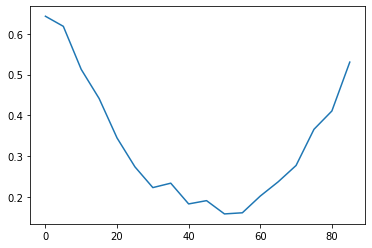

In [41]:
angle_sweep = range(0, 90, 5)
plt.plot(angle_sweep, p_val_df['mean'])

Text(0.5, 1.0, 'Angle of Rotation vs Bootstrap xor/rxor P-Value')

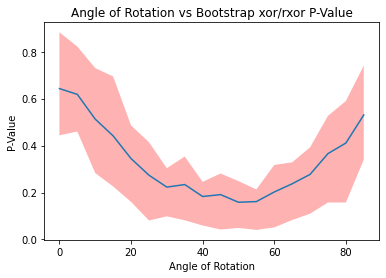

In [48]:
qunatiles = np.nanquantile(p_val_df.iloc[:,:-1], [0.25, 0.75], axis=1)
plt.fill_between(
    angle_sweep, qunatiles[0], qunatiles[1], facecolor="r", alpha=0.3
)
plt.plot(angle_sweep, p_val_df['mean'])
plt.xlabel("Angle of Rotation")
plt.ylabel("P-Value")
plt.title("Angle of Rotation vs Bootstrap xor/rxor P-Value")

In [ ]:
# from joblib import Parallel, delayed
# import time

In [ ]:
# # np array to store p values 
# p_val_list_2 = []

# start = time.time()
# # try parallel
# Parallel(n_jobs=-1)(delayed(p_val_list_2.append(bootstrap(angle_sweep = range(0, 90, 5), n_samples = 100, reps = 100000)))(i) 
#                     for i in range(100))

# end = time.time()

# print('\nThe function took {:.2f} s to compute.'.format(end - start))